In [1]:
from typing import List, Callable
from dataclasses import dataclass

import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display

from src.genetic import fitness
from src.simulation import Simulation
from src.pid import PIDController

In [2]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [3]:
@dataclass
class Genome:
    p: float
    i: float
    d: float
    generation: int
    fitness: float = 0.0
    is_mutated: bool = False
    got_killed: bool = True

In [4]:
def generate_population(population_size: int, p_min: float, p_max: float, i_min: float, i_max: float, d_min: float, d_max: float) -> List[Genome]:
    p = np.random.uniform(p_min, p_max, population_size)
    i = np.random.uniform(i_min, i_max, population_size)
    d = np.random.uniform(d_min, d_max, population_size)
    population = np.array([p, i, d]).transpose()
    
    genomes = []
    for genome in population:
        genomes.append(Genome(p=genome[0], i=genome[1], d=genome[2], generation=1))
        
    return genomes

In [5]:
def select_genomes(selection_size: int, genomes: List[Genome], errors: List[float]) -> List[Genome]:
    assert selection_size % 2 == 0
    indices_of_smallest_error = sorted(range(len(errors)), key=lambda i: errors[i])[:selection_size]
    best_genomes = [genomes[i] for i in indices_of_smallest_error]

    for genome in best_genomes:
        genome.got_killed = False
    
    return best_genomes

In [125]:
def calculate_fitness(genome: Genome, simulation: Simulation, setpoints: List[float], external_force: List[float], fitness_func: Callable) -> float:
    pid_controller = PIDController(genome.p, genome.i, genome.d, setpoint=setpoints[0])
    
    positions = []
    position = 0
    for idx, setpoint in enumerate(setpoints):
        pid_controller.setpoint = setpoint
        new_angle = pid_controller.next(position)
        _, _, position = simulation.next(new_angle, external_force[idx])
        positions.append(position)
        
    error = fitness_func(positions, setpoints, weight_factor)
    return error, positions

In [7]:
def crossover(parents: List[Genome], crossover_rate: int) -> List[Genome]:
    children = []
    for mother, father in batch(parents, n=2):
        p_mean, i_mean, d_mean = (mother.p + father.p) / 2, (mother.i + father.i) / 2, (mother.d + father.d) / 2
        p_std_dev, i_std_dev, d_std_dev = abs(mother.p - p_mean), abs(mother.i - i_mean), abs(mother.d - d_mean)
        
        p_children = np.random.normal(p_mean, p_std_dev, crossover_rate)
        i_children = np.random.normal(i_mean, i_std_dev, crossover_rate)
        d_children = np.random.normal(d_mean, d_std_dev, crossover_rate)
        
        for p, i, d in zip(p_children, i_children, d_children):
            children.append(Genome(p=p, i=i, d=d, generation=mother.generation + 1))
            
    return children

In [158]:
def mutate(children: List[Genome], mutation_probability: float, mutation_impact: float) -> List[Genome]:
    p_vals = [genome.p for genome in children]
    i_vals = [genome.i for genome in children]
    d_vals = [genome.d for genome in children]

    p_mean = np.mean(p_vals)
    p_std_dev = np.std(p_vals)
    i_mean = np.mean(i_vals)
    i_std_dev = np.std(i_vals)
    d_mean = np.mean(d_vals)
    d_std_dev = np.std(d_vals)
    
    mutated_genomes = []
    for genome in children:
        if np.random.rand() < mutation_probability:
            mutated_p = np.random.normal(p_mean, p_std_dev * mutation_impact)
            mutated_i = np.random.normal(i_mean, i_std_dev * mutation_impact)
            mutated_d = np.random.normal(d_mean, d_std_dev * mutation_impact)
            mutated_genomes.append(Genome(p=mutated_p, i=mutated_i, d=mutated_d, generation=genome.generation, is_mutated=True))
        else:
            mutated_genomes.append(genome)
            
    return mutated_genomes

In [228]:
population_size = 120
selection_size = 40
crossover_rate = 6
mutation_probability = 0.2
mutation_impact = 5
num_generations = 20
p_min, p_max = -30, 30
i_min, i_max = -1, 1
d_min, d_max = -300, 300

In [256]:
fps = 30
setpoints = [-10] * fps * 10 + [5] * fps * 10 + [0] * fps * 40
external_force = [0] * fps * 30 + [1] * fps * 30
mass = 0.2
delta_t = 1 / fps
weight_factor = 1.4

In [259]:
population = generate_population(population_size, p_min, p_max, i_min, i_max, d_min, d_max)
all_genomes = population.copy()
smallest_error = None
best_genome = None
best_genome_positions = None
for generation in range(num_generations):
    errors = []
    for genome in population:
        error, positions = calculate_fitness(genome, Simulation(mass=mass, delta_t=delta_t), setpoints, external_force, fitness)
        genome.fitness = error
        if smallest_error is None or genome.fitness < smallest_error:
            smallest_error = genome.fitness
            best_genome = genome
            best_genome_positions = positions
        errors.append(error)

    print(f'Min. Error: {np.min(errors)}')

    parents = select_genomes(selection_size, population, errors)
    children = crossover(parents, crossover_rate)
    population = mutate(children, mutation_probability, mutation_impact)
    all_genomes += population

print(best_genome)

Min. Error: 2856.919785568776
Min. Error: 1756.2369840581296
Min. Error: 1554.4228779638022
Min. Error: 1434.4412823460118
Min. Error: 1438.8556849874212
Min. Error: 1426.2626194851132
Min. Error: 1425.595739365543
Min. Error: 1420.7000629847191
Min. Error: 1422.7817528472158
Min. Error: 1424.8175692500852
Min. Error: 1424.716503080241
Min. Error: 1414.4578647666574
Min. Error: 1412.9126076803273
Min. Error: 1412.2918120330608
Min. Error: 1413.062087209671
Min. Error: 1414.596780033076
Min. Error: 1414.5464491017085
Min. Error: 1413.0531865401726
Min. Error: 1413.302327422729
Min. Error: 1412.5671588185412
Genome(p=-11.27216080412917, i=-0.033401362444796794, d=-263.6925895585011, generation=14, fitness=1412.2918120330608, is_mutated=False, got_killed=False)


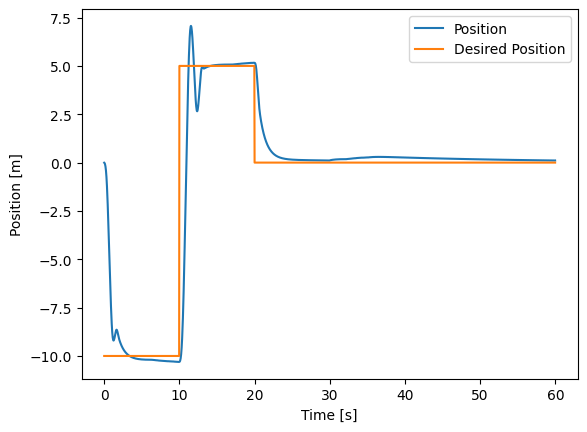

In [253]:
plt.plot(np.arange(len(setpoints)) / fps, best_genome_positions)
plt.plot(np.arange(len(setpoints)) / fps, setpoints)

plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['Position', 'Desired Position'])

plt.show()

In [191]:
# TODO: Make checkbox to ignore Outliers or not

def update_plot(generation, show_selection):
    plot_data = {
        'P': [genome.p for genome in all_genomes if genome.generation == generation],
        'I': [genome.i for genome in all_genomes if genome.generation == generation],
        'D': [genome.d for genome in all_genomes if genome.generation == generation],
        'fitness': [genome.fitness for genome in all_genomes if genome.generation == generation],
        'got_killed': [genome.got_killed for genome in all_genomes if genome.generation == generation],
        'mutated': [genome.is_mutated for genome in all_genomes if genome.generation == generation]
    }
    
    fig = px.scatter_3d(plot_data, x='P', y='I', z='D', color='got_killed' if show_selection else 'fitness', symbol='mutated')
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[p_min, p_max]),
            yaxis=dict(range=[i_min, i_max]),
            zaxis=dict(range=[d_min, d_max])
        ),
        width=800,
        height=800
    )
    fig.show()

generation_slider = widgets.IntSlider(value=1, min=1, max=num_generations, description='Generation')
show_selection_checkbox = widgets.Checkbox(value=False, description='Show Selection')

interactive_plot = widgets.interactive(update_plot, generation=generation_slider, show_selection=show_selection_checkbox)
display(interactive_plot)

interactive(children=(IntSlider(value=1, description='Generation', max=20, min=1), Checkbox(value=False, descr…